# 	The	language classification	problem

Paper experiment setup: While in this study, in order to enable training of SOMs, each language corpus was divided into samples where the length of each sample was set to 1, 000 symbols. The data for each language was preprocessed such that the text included only lower case letters and spaces. All punctuation was removed. Lastly, all text used the 26-letter ISO basic Latin alphabet, i.e., the alphabet for both training and test data was the same and it included 27 symbols. 

In [41]:
import re
import numpy as np
import os
import random
import pickle
from collections import defaultdict

In [42]:
alphabet = 'abcdefghijklmnopqrstuvwxyz '  # 27 symbols including space
alphabet_size = len(alphabet)
hd_dimension1 = 100  
hd_dimension2 = 1000

In [43]:
def ngrams(text, n=3):
    ngrams = []
    for i in range(len(text) - n + 1):
        ngram = text[i:i + n]
        ngrams.append(ngram)
    
    return ngrams


In [44]:
def preprocess(text):
    # Lowercase the text
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    return text

example1 = '4	Ah, dernier truc : l’idéal est de vider la cuisine d’un trait en prenant bien le temps de ranger et non pas petit à petit mais dans l’urgence comme j’ai fait car cela devient vite le bazar.'
processed_text1 = preprocess(example1)

print("Original text:")
print(example1)
print("\nPreprocessed text:")
print(processed_text1)


Original text:
4	Ah, dernier truc : l’idéal est de vider la cuisine d’un trait en prenant bien le temps de ranger et non pas petit à petit mais dans l’urgence comme j’ai fait car cela devient vite le bazar.

Preprocessed text:
ah dernier truc  lidal est de vider la cuisine dun trait en prenant bien le temps de ranger et non pas petit  petit mais dans lurgence comme jai fait car cela devient vite le bazar


In [45]:
ngrams_example1 = ngrams(processed_text1)

In [46]:
def split_data(file_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    with open(file_path, 'r') as file:
        sentences = file.readlines()

    random.shuffle(sentences)

    total_sentences = len(sentences)
    train_end = int(train_ratio * total_sentences)
    val_end = train_end + int(val_ratio * total_sentences)

    train_sentences = sentences[:train_end]
    val_sentences = sentences[train_end:val_end]
    test_sentences = sentences[val_end:]

    base, ext = os.path.splitext(file_path)
    with open(f"{base}_train{ext}", 'w') as train_file:
        train_file.writelines(train_sentences)
    with open(f"{base}_val{ext}", 'w') as val_file:
        val_file.writelines(val_sentences)
    with open(f"{base}_test{ext}", 'w') as test_file:
        test_file.writelines(test_sentences)



In [47]:
def ngram_stat(ngrams):
    s_i = np.zeros(alphabet_size ** n)

    # Create a mapping from n-gram to index in vector s
    ngram_to_index = defaultdict(lambda: len(ngram_to_index))
    
    for ngram in ngrams:
        index = ngram_to_index[ngram]
        s_i[index] += 1

    return s_i  

In [48]:
def create_dataset_stat(folder_path):
    dataset = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            sentences = read_sentences(file_path)
            for sentence in sentences:
                preprocessed_sentence = preprocess(sentence)
                ngrams_sentence = ngrams(preprocessed_sentence)
                s_i = ngram_sta(ngrams_sentence)
            dataset[filename] = s_i  

    return dataset

# Hyperdimensional Centroid Language classification

In [49]:
def initialize_hd_vectors(ngrams, d):
    hd_vectors = {}
    for ngram in ngrams:
        hd_vectors[ngram] = np.random.choice([-1, 1], size=(d,))
    return hd_vectors


In [50]:
def init_memory(alphabet_size, hd_dimension):
    H = np.random.choice([-1, 1], size=(hd_dimension, alphabet_size))
    return H

def get_hd_vector(symbol_index, item_memory):
    # Retrieve the HD vector for the given symbol index from item memory H
    return item_memory[:, symbol_index]


In [51]:
# Initialize item memory
item_memory = init_memory(alphabet_size, hd_dimension1)

# Retrieve HD vector for a specific symbol (e.g., 'a')
symbol_index = alphabet.index('a')
hd_vector_a = get_hd_vector(symbol_index, item_memory)

print(f"Item memory (H):\n{item_memory.shape}")
print(f"\nHD vector for symbol 'a' (H[a]):\n{hd_vector_a.shape}")

Item memory (H):
(100, 27)

HD vector for symbol 'a' (H[a]):
(100,)


In [52]:
def rho(hd_vector, times, shift=5):
    if times == 0:
        return hd_vector
    else:
        # Rotate the hd_vector by 'shift' positions
        return rho(np.roll(hd_vector, shift), shift, times - 1)


# forming HD vector of an n-gram

From paper: for the trigram ‘cba’ will be mapped to its HD vector as follows:
ρ
1
(Hc)  ρ
2
(Hb)  ρ
3
(Ha) the process of forming HD vector of an n-gram can be formalized as follows

In [53]:
def ngram_HD(ngram, hd_dimension):
    ngram_hd = np.ones((hd_dimension,) )
    for i in range(len(ngram)):
        sym_idx = alphabet.index(ngram[i])
        hd_vector = get_hd_vector(sym_idx, item_memory)
        # apply i+1 times rho
        hd_vector = rho(hd_vector, i+1)
        ngram_hd = ngram_hd*hd_vector
    return ngram_hd

ngram_example = 'cba'
example_output = ngram_HD(ngram_example, 100)
print('cab hd vector:', example_output)

cab hd vector: [-1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1.  1.  1.
  1. -1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.
  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.
  1.  1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.]


# mapping the whole n-gram statistics s

In [54]:
def ngram_stat_h(ngrams, hd_dimension, n=3, alphabet_size=alphabet_size):

    h = np.zeros((hd_dimension,))
    # Initialize vector s
    num_ngrams = alphabet_size ** n
    s_i = np.zeros(num_ngrams)

    # Create a mapping from n-gram to index in vector s
    ngram_to_index = defaultdict(lambda: len(ngram_to_index))
    
    for ngram in ngrams:
        index = ngram_to_index[ngram]
        s_i[index] += 1
        
    for ngram in ngrams:    
        ngram_hd = ngram_HD(ngram, hd_dimension)
        h += s_i[ngram_to_index[ngram]]*ngram_hd
    return h



In [55]:
example1_h_stat = ngram_stat_h(ngrams_example1, hd_dimension1)
print('a short sentence example n-gram statistics:\n', example1_h_stat)

a short sentence example n-gram statistics:
 [-48. -38.  50. -24.  46. -26.  12. -24. -18. -64.  -8.  22.  22.  56.
 -44.  18.  20.  28.  46.   0. -14.  -8.  -2.  68.  16.   6. -14.  62.
  -4.  -2.  -8. -56. -18.   8. -16. -12.   8. -56. -50. -38. -28.  28.
 -10.  40. -30. -42. -62. -10. -28. -36.  62.  26.  22. -60. -44.  -6.
  14.  -6. -24.  44.  24. -42.  20. -48.  -2.  50.  -2. -26. -30.  24.
  16. -24. -46.  36. -38.  28.  76. -12. -12.  32.   6. -12.  -4.  -4.
  14.   6.  14.   0.  30.   4. -24. -22. -38.   8.   2. -32.  -6.  22.
  24.  36.]


In [56]:
l2_norm_example1 = np.linalg.norm(example1_h_stat)

normalized_array = example1_h_stat / l2_norm_example1

print("\nL2 norm of the array:")
print(l2_norm_example1)
print("\nNormalized array:")
print(normalized_array)



L2 norm of the array:
317.71056010148607

Normalized array:
[-0.15108091 -0.11960572  0.15737595 -0.07554045  0.14478587 -0.08183549
  0.03777023 -0.07554045 -0.05665534 -0.20144121 -0.02518015  0.06924542
  0.06924542  0.17626106 -0.13849083  0.05665534  0.06295038  0.08813053
  0.14478587  0.         -0.04406526 -0.02518015 -0.00629504  0.21403129
  0.0503603   0.01888511 -0.04406526  0.19514617 -0.01259008 -0.00629504
 -0.02518015 -0.17626106 -0.05665534  0.02518015 -0.0503603  -0.03777023
  0.02518015 -0.17626106 -0.15737595 -0.11960572 -0.08813053  0.08813053
 -0.03147519  0.12590076 -0.09442557 -0.13219579 -0.19514617 -0.03147519
 -0.08813053 -0.11331068  0.19514617  0.08183549  0.06924542 -0.18885114
 -0.13849083 -0.01888511  0.04406526 -0.01888511 -0.07554045  0.13849083
  0.07554045 -0.13219579  0.06295038 -0.15108091 -0.00629504  0.15737595
 -0.00629504 -0.08183549 -0.09442557  0.07554045  0.0503603  -0.07554045
 -0.14478587  0.11331068 -0.11960572  0.08813053  0.23921144 -0

# 21 languages centroid HD

# D1 = 100

In [57]:
def read_sentences(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        sentences = file.readlines()
    return sentences

In [58]:
def pick_random_sentences(sentences, num_sentences):
    return random.sample(sentences, min(num_sentences, len(sentences)))

In [59]:
folder_path = './news'

def HD_centroid_1(hd_dimension):
    # Initialize item memory
    item_memory = init_memory(alphabet_size, hd_dimension)

    HD_centroids = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                preprocessed_text = preprocess(text)
                ngrams_text = ngrams(preprocessed_text)
                h_stat = ngram_stat_h(ngrams_text, hd_dimension)
                # L2 normalize h
                l2_norm = np.linalg.norm(h_stat)
                normed_h = h_stat / l2_norm
                HD_centroids[filename.split('_')[0]] = normed_h
    return HD_centroids

def HD_centroid(hd_dimension):
    # Initialize item memory
    item_memory = init_memory(alphabet_size, hd_dimension)

    HD_centroids = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            centroid = []
            file_path = os.path.join(folder_path, filename)
            sentences = read_sentences(file_path)
            sentences = pick_random_sentences(sentences, 1000)
            for sentence in sentences:
                preprocessed_sentence = preprocess(sentence)
                ngrams_sentence = ngrams(preprocessed_sentence)
                h_stat = ngram_stat_h(ngrams_sentence, hd_dimension)
                # L2 normalize h
                epsilon = 1e-4
                l2_norm = np.linalg.norm(h_stat)
                normed_h = h_stat / (l2_norm + epsilon)
                centroid.append(normed_h)
            mean = np.mean(np.array(centroid), axis=0)
            HD_centroids[filename.split('_')[0]] = mean
            print(f'Language: {filename.split('_')[0]} HD centroid is generated')
    return HD_centroids

In [60]:
HD_centroids_100dimension = HD_centroid(hd_dimension1)

Language: bul HD centroid is generated
Language: ces HD centroid is generated
Language: dan HD centroid is generated
Language: deu HD centroid is generated
Language: ell HD centroid is generated
Language: eng HD centroid is generated
Language: est HD centroid is generated
Language: fin HD centroid is generated
Language: fra HD centroid is generated
Language: hun HD centroid is generated
Language: ita HD centroid is generated
Language: lav HD centroid is generated
Language: lit-lit HD centroid is generated
Language: nld HD centroid is generated
Language: pol HD centroid is generated
Language: por HD centroid is generated
Language: ron HD centroid is generated
Language: slk HD centroid is generated
Language: slv HD centroid is generated
Language: spa HD centroid is generated
Language: swe HD centroid is generated


In [61]:
with open('HD_centroids_100dimension.pkl', 'wb') as f:
    pickle.dump(HD_centroids_100dimension, f)

print("Dictionary saved to HD_centroids_100dimension.pkl")


Dictionary saved to HD_centroids_100dimension.pkl


In [62]:
print('Italian HD cenroid vector:\n')
HD_centroids_100dimension['ita']

Italian HD cenroid vector:



array([ 0.01410931, -0.02515751, -0.02130151, -0.0342208 ,  0.00653859,
        0.01983423,  0.00801386,  0.0218325 , -0.00249456, -0.03073732,
       -0.03098773, -0.02407231,  0.04275401, -0.00189254, -0.0118898 ,
        0.0587213 ,  0.00486181,  0.00284181, -0.00802436, -0.02964165,
        0.05118087, -0.04752298, -0.05297094, -0.01505934,  0.00430098,
       -0.05853088, -0.02116637,  0.07017028,  0.01150603, -0.00142599,
       -0.00704003, -0.04379029, -0.01025125, -0.04369585, -0.01682518,
        0.0286378 , -0.0525305 , -0.04121154,  0.00572425, -0.05812761,
       -0.00603233, -0.04252356,  0.00796642,  0.01490991,  0.00463633,
        0.01688826, -0.03355317,  0.00801216, -0.02709017,  0.03716753,
        0.06850792,  0.02778843,  0.03627792, -0.01384378,  0.02664149,
       -0.00051707,  0.01329149, -0.05484198,  0.00183583,  0.02115971,
        0.00401447,  0.00670957,  0.05007282, -0.07410917, -0.0611426 ,
        0.00231525, -0.02188881,  0.03460967, -0.06253206,  0.01

# Test phase using Europarl Parallel Corpus

In [63]:
# Load the dictionary from the file
with open('HD_centroids_100dimension.pkl', 'rb') as f:
    HD_centroids_100dimension = pickle.load(f)




In [64]:
test_path = './finaltest'
classes = HD_centroids_100dimension.keys()

def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def classify(file_path, centroids, hd_dimension):
    sentences = read_sentences(file_path)
    sentences = pick_random_sentences(sentences, num_sentences=100)
    confusion_matrix = {}
    
    for sentence in sentences:
        preprocessed_sentence = preprocess(sentence)
        ngrams_sentence = ngrams(preprocessed_sentence)
        h_stat = ngram_stat_h(ngrams_sentence, hd_dimension)
        # L2 normalize h
        l2_norm = np.linalg.norm(h_stat)
        epsilon = 1e-4
        normed_h = h_stat / (l2_norm + epsilon)
        similarity = {}
        for label, centroid in centroids.items():
            similarity[label] = cosine_similarity(normed_h, centroid)
            try:
                confusion_matrix[label] 
            except KeyError:
                confusion_matrix[label] = 0
        pred = max(similarity, key=similarity.get)
        confusion_matrix[pred] += 1
        # try:
        #     confusion_matrix[pred] += 1
        # except KeyError:
        #     confusion_matrix[pred] = 0
    return confusion_matrix
        

In [72]:
cm_name = {'sv':'swe','nl':'nld','da':'dan','pt':'por','it':'ita','fi':'fin','en':'eng','el':'ell','lv':'lav','sk':'slk','lt':'lit-lit','et':'est','pl':'pol','hu':'hun','sl':'slv','bg':'bul','ro':'ron','fr':'fra','es':'spa','de':'deu','cs':'ces'}

In [73]:
cm_name

{'sv': 'swe',
 'nl': 'nld',
 'da': 'dan',
 'pt': 'por',
 'it': 'ita',
 'fi': 'fin',
 'en': 'eng',
 'el': 'ell',
 'lv': 'lav',
 'sk': 'slk',
 'lt': 'lit-lit',
 'et': 'est',
 'pl': 'pol',
 'hu': 'hun',
 'sl': 'slv',
 'bg': 'bul',
 'ro': 'ron',
 'fr': 'fra',
 'es': 'spa',
 'de': 'deu',
 'cs': 'ces'}

In [74]:
results = {}
for filename in os.listdir(test_path):
    
    language = filename.split("v7.")[1]
    language = language.split("-")[0]

    file_path = os.path.join(test_path, filename)
    result = classify(file_path, HD_centroids_100dimension, hd_dimension1)
    results[cm_name[language]] = result
    

C:\Users\jixia\AppData\Local\Temp\ipykernel_5032\3781186729.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm_a * norm_b)


In [79]:
import pandas as pd
df = pd.DataFrame(results)
labels = df.index.union(df.columns)
df = df.reindex(index=labels, columns=labels)

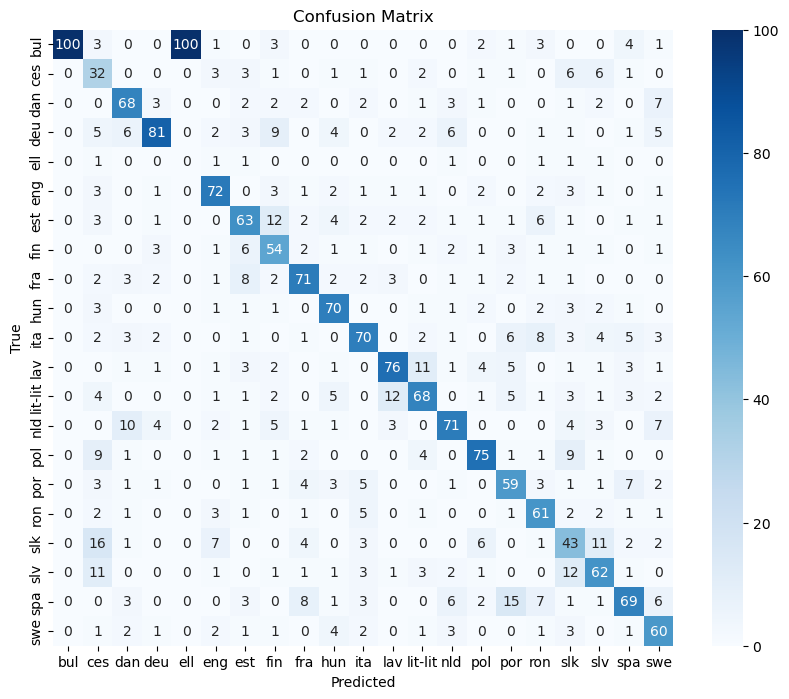

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt='d', cmap='Blues', xticklabels=df.columns, yticklabels=df.index)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# D2 = 1000

In [82]:
item_memory = init_memory(alphabet_size, hd_dimension2)
HD_centroids_1000dimension = HD_centroid(hd_dimension2)

Language: bul HD centroid is generated
Language: ces HD centroid is generated
Language: dan HD centroid is generated
Language: deu HD centroid is generated
Language: ell HD centroid is generated
Language: eng HD centroid is generated
Language: est HD centroid is generated
Language: fin HD centroid is generated
Language: fra HD centroid is generated
Language: hun HD centroid is generated
Language: ita HD centroid is generated
Language: lav HD centroid is generated
Language: lit-lit HD centroid is generated
Language: nld HD centroid is generated
Language: pol HD centroid is generated
Language: por HD centroid is generated
Language: ron HD centroid is generated
Language: slk HD centroid is generated
Language: slv HD centroid is generated
Language: spa HD centroid is generated
Language: swe HD centroid is generated


In [83]:
results_1000 = {}
for filename in os.listdir(test_path):
    
    language = filename.split("v7.")[1]
    language = language.split("-")[0]

    file_path = os.path.join(test_path, filename)
    result = classify(file_path, HD_centroids_1000dimension, hd_dimension2)
    results_1000[cm_name[language]] = result

C:\Users\jixia\AppData\Local\Temp\ipykernel_5032\3781186729.py:8: RuntimeWarning: invalid value encountered in scalar divide
  return dot_product / (norm_a * norm_b)


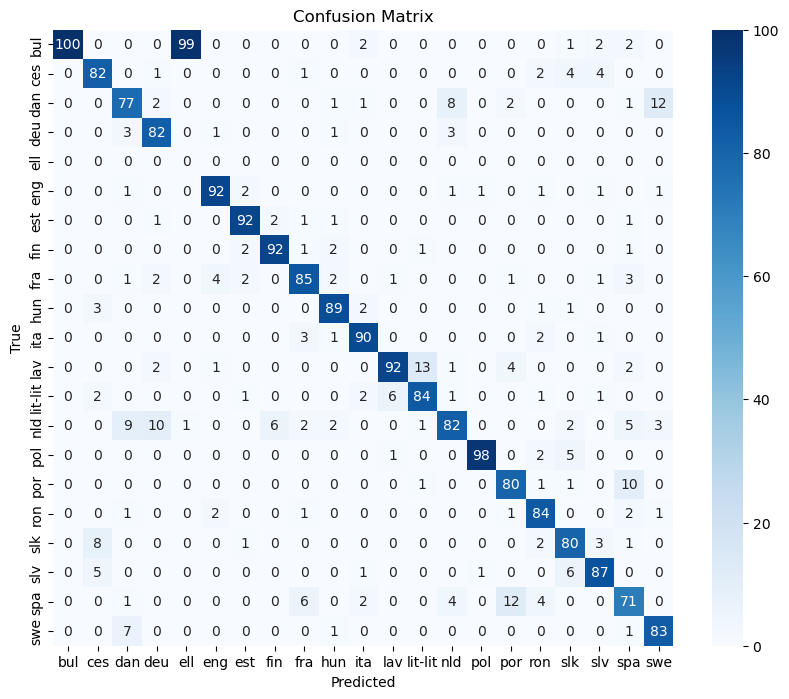

In [84]:
df_1000 = pd.DataFrame(results_1000)
labels = df.index.union(df_1000.columns)
df_1000 = df_1000.reindex(index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(df_1000, annot=True, fmt='d', cmap='Blues', xticklabels=df_1000.columns, yticklabels=df_1000.index)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and F1-score of HPC

In [92]:
from sklearn.metrics import accuracy_score, f1_score

def performance(result_df):
    labels = []
    predicts = []
    for label in result_df.index:
        for predict in result_df.columns:
            count = result_df.at[label, predict]
            labels.extend([label] * count)
            predicts.extend([predict] * count)
    accuracy = accuracy_score(labels, predicts)
    f1 = f1_score(labels, predicts, average='macro')
    return accuracy, f1

accuracy_100, f1_100 = performance(df)
print(f'100 dimension HP 21 language classification accuarcy: {accuracy_100*100}%, F1 score: {f1_100}')
accuracy_1000, f1_1000 = performance(df_1000)
print(f'1000 dimension HP 21 language classification accuarcy: {accuracy_1000*100}%, F1 score: {f1_1000}')

100 dimension HP 21 language classification accuarcy: 63.095238095238095%, F1 score: 0.6142028542709463
1000 dimension HP 21 language classification accuarcy: 82.0%, F1 score: 0.8054608249220679
